### Constants

In [33]:
import numpy as np
import math
import matplotlib.pyplot as plt
K = 273.15
G = 6.674e-11
gamma = 0.3
S_0 = 917
sigma = 5.670367e-8
timestep = 1
R = 0.2

albedo_w = 0.75
albedo_b = 0.25
albedo_g = 0.5
T_min = 278.15
T_max = 313.15

solar_constant = 1367  # W/m^2
solar_multiplier = 1  # No change in solar constant

### Helper functions

Note that `time` is in unit `day`.

In [3]:
def solar_declination(time): 
    '''
    Calculate solar declination angle in radians for a given day of the year.
    Time is given in days, where day 1 is Winter Solstice (around December 21).
    '''
    gamma = 2 * math.pi * ((time%365) - 1)/365
    return (0.006918
            - 0.399912*math.cos(gamma) + 0.070257*math.sin(gamma)
            - 0.006758*math.cos(2*gamma) + 0.000907*math.sin(2*gamma)
            - 0.002697*math.cos(3*gamma) + 0.001480*math.sin(3*gamma))

def eccentricity_corrector(time):
    '''
    Calculate eccentricity correction factor for a given day of the year.
    '''
    return 1 + 0.033 * math.cos(2*math.pi * (time%365)/365)

def hour_angle_sunset(latitude, delta):
    '''
    Calculate hour angle at sunset for a given latitude and solar declination.
    Latitude is given in degrees (positive for northern hemisphere, negative for southern).
    Delta is given in radians.
    '''
    latitude_rad = math.radians(latitude)
    cos_omega_s = - math.tan(latitude_rad) * math.tan(delta)
    cos_omega_s = max(-1.0, min(1.0, cos_omega_s))
    return math.acos(cos_omega_s)

def daily_radiation(time, latitude,
                    solar_constant=1367, # W/m^2
                    solar_multiplier=1):
    '''
    Calculate daily solar radiation for a given time and latitude.
    Time is given in days, where day 1 is Winter Solstice (around December 21).
    Latitude is given in degrees (positive for northern hemisphere, negative for southern).
    '''
    latitude_rad = math.radians(latitude)
    E_0 = eccentricity_corrector(time)
    delta = solar_declination(time)
    omega_s = hour_angle_sunset(latitude_rad, delta)
    # print(f"Day {time}, Lat {latitude}: delta={math.degrees(delta)}, omega_s={math.degrees(omega_s)}")

    # Daily mean insolation (zero at night), W/m^2
    daily_insolation = \
        (1 / math.pi) * \
        (solar_constant * solar_multiplier) * E_0 * \
        (omega_s * math.sin(latitude_rad) * math.sin(delta) + \
         math.cos(latitude_rad) * math.cos(delta) * math.sin(omega_s))

    # Clamp to zero if sun never rises
    return max(daily_insolation, 0)

def area_fraction(latitude):
   latitude = math.radians(latitude)
   return abs((math.sin(latitude + 1/180 * math.pi) - math.sin(latitude))/2)

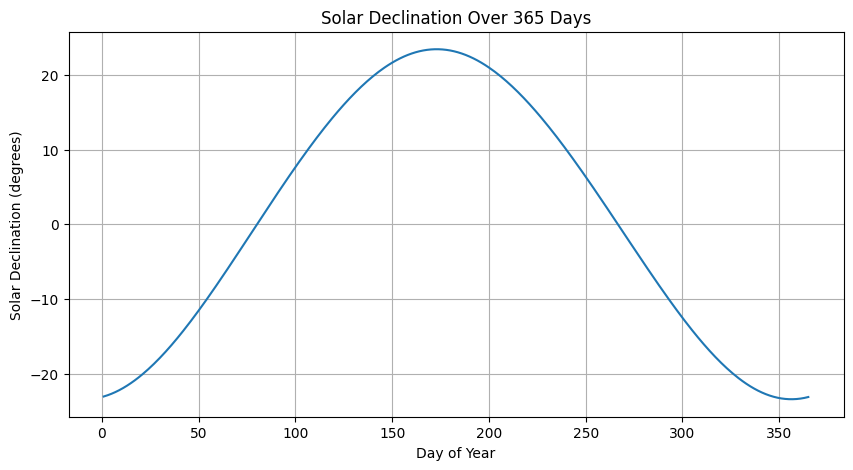

In [4]:
days = np.arange(1, 366)
declinations = [math.degrees(solar_declination(day)) for day in days]

plt.figure(figsize=(10, 5))
plt.plot(days, declinations)
plt.xlabel('Day of Year')
plt.ylabel('Solar Declination (degrees)')
plt.title('Solar Declination Over 365 Days')
plt.grid(True)
plt.show()

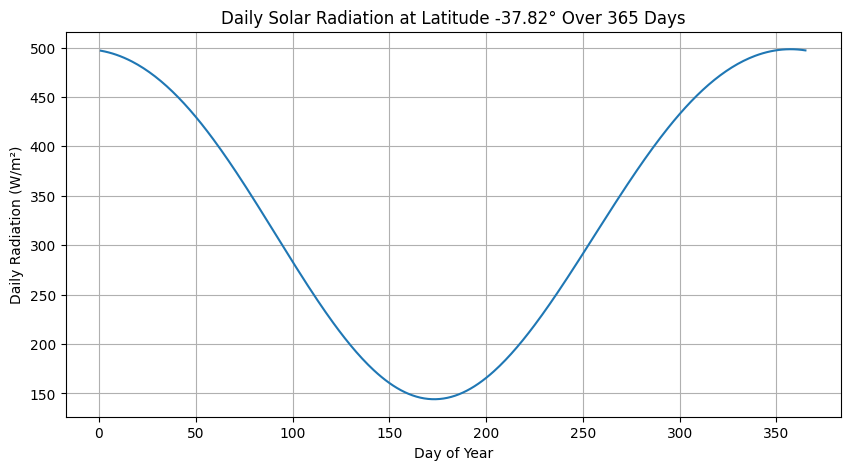

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(days, [daily_radiation(day, -37.82) for day in days])
plt.xlabel('Day of Year')
plt.ylabel('Daily Radiation (W/m²)')
plt.title('Daily Solar Radiation at Latitude -37.82° Over 365 Days')
plt.grid(True)
plt.show()

## Initial Conditions & Main Code

### Iteration 4: Only Black Daisies

In [95]:
# Solar multiplier
local_solar_multiplier = 2.5  # Simulates different solar intensities

# Initial conditions
T_p_seq = []
A_w_seq = []
A_b_seq = []
white_daisy_by_latitude = []
black_daisy_by_latitude = []

A_g = np.ones(180) * 0.0  # Initial bare ground area fraction
A_w = np.ones(180) * 0.0  # Initial white daisy area fraction
A_b = np.ones(180) * 0.0  # Initial black daisy area fraction

areas = np.array([area_fraction(lat - 90) for lat in range(180)])
albedo_p = np.zeros(180)

years = 5
for day in range(365 * years):
    delta_A_w = np.zeros(180)
    delta_A_b = np.zeros(180)
    T = np.zeros(180)

    for lat in range(0, 180):
        A_g[lat] = 1 - A_w[lat] - A_b[lat]
        albedo_p[lat] = A_g[lat] * albedo_g + A_w[lat] * albedo_w + A_b[lat] * albedo_b
        I_0 = daily_radiation(day, lat - 90, solar_constant=solar_constant, solar_multiplier=local_solar_multiplier)
        # print(I_0)
        T[lat] = (I_0 * (1 - albedo_p[lat]) / sigma) ** 0.25 if I_0 > 0 else T_min

        T_w = ((R * I_0 / sigma * (albedo_p[lat] - albedo_w)) + T[lat] ** 4) ** 0.25
        T_b = ((R * I_0 / sigma * (albedo_p[lat] - albedo_b)) + T[lat] ** 4) ** 0.25

        beta_w = 1 - 0.003265 * (295.65 - T_w) ** 2 if T_min < T_w < T_max else 0
        beta_b = 1 - 0.003265 * (295.65 - T_b) ** 2 if T_min < T_b < T_max else 0

        delta_A_w[lat] = A_w[lat] * (A_g[lat] * beta_w - gamma) * timestep
        delta_A_b[lat] = A_b[lat] * (A_g[lat] * beta_b - gamma) * timestep

        A_w[lat] += delta_A_w[lat]
        A_b[lat] += delta_A_b[lat]

    # A_w = np.clip(A_w, 1e-6, 1.0)
    A_b = np.clip(A_b, 1e-6, 1.0)

    T_p_new = np.dot(T, areas)
    T_p_seq.append(T_p_new)
    A_w_seq.append(np.mean(A_w))
    A_b_seq.append(np.mean(A_b))
    white_daisy_by_latitude.append(A_w.copy())
    black_daisy_by_latitude.append(A_b.copy())

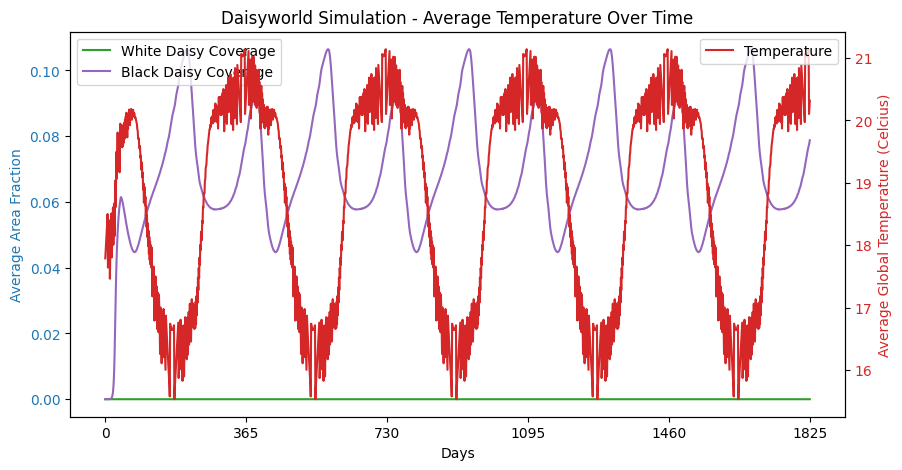

In [96]:
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.set_xticks(np.arange(0, len(A_w_seq)+1, 365))
ax1.set_xticklabels([str(i) for i in np.arange(0, len(A_w_seq)+1, 365)])

color1 = 'tab:blue'
ax1.set_xlabel('Days')
ax1.set_ylabel('Average Area Fraction', color=color1)
ax1.plot(A_w_seq, label='White Daisy Coverage', color='tab:green')
ax1.plot(A_b_seq, label='Black Daisy Coverage', color='tab:purple')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Average Global Temperature (Celcius)', color=color2)
ax2.plot(np.array(T_p_seq) - K, label='Temperature', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)
ax2.legend(loc='upper right')

plt.title('Daisyworld Simulation - Average Temperature Over Time')
plt.show()

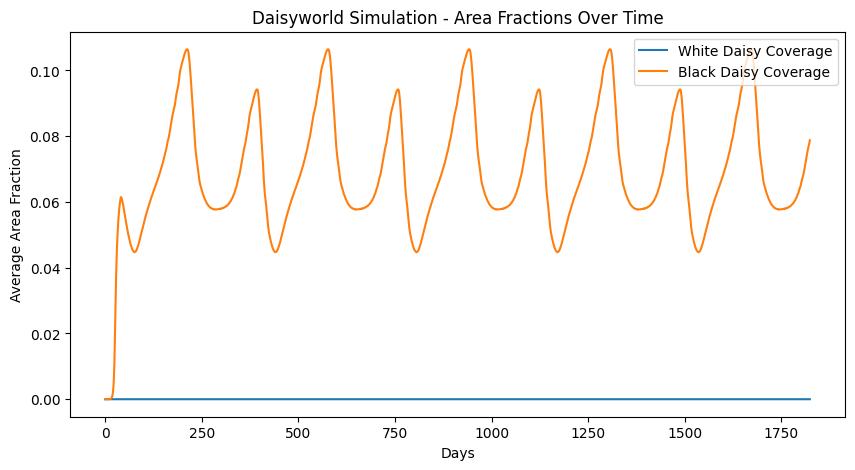

In [97]:
plt.figure(figsize=(10, 5))
plt.plot(A_w_seq, label = 'White Daisy Coverage')
plt.plot(A_b_seq, label = 'Black Daisy Coverage')
plt.xlabel('Days')
plt.ylabel('Average Area Fraction')
plt.title('Daisyworld Simulation - Area Fractions Over Time')
plt.legend()
plt.show()

**Plotting**

> Results suggest that daisy growth does not fluctuate significantly with the seasonal changes in sunlight or seasonal changes in temperture in Daisyworld.

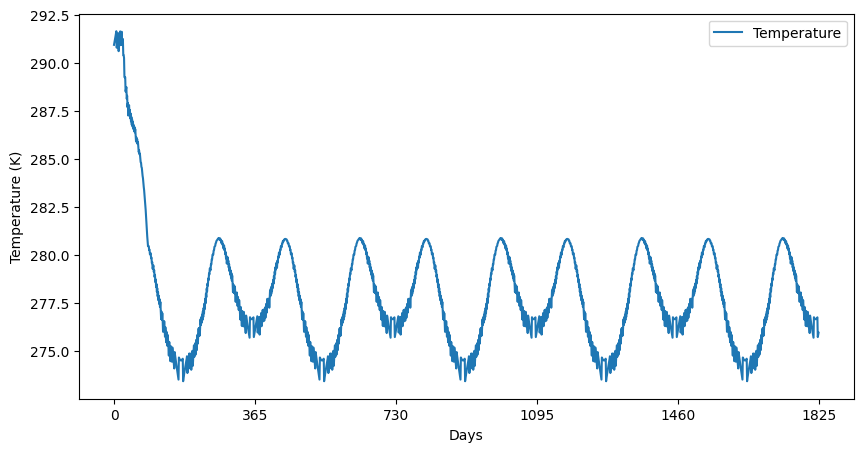

In [91]:
plt.figure(figsize=(10, 5))
plt.plot(T_p_seq, label = 'Temperature')
plt.xlabel('Days')
plt.ylabel('Temperature (K)')
plt.legend()
plt.xticks(
    ticks=np.arange(0, len(T_p_seq)+1, 365),
    labels=[str(i) for i in range(0, len(T_p_seq)+1, 365)]
)
plt.show()

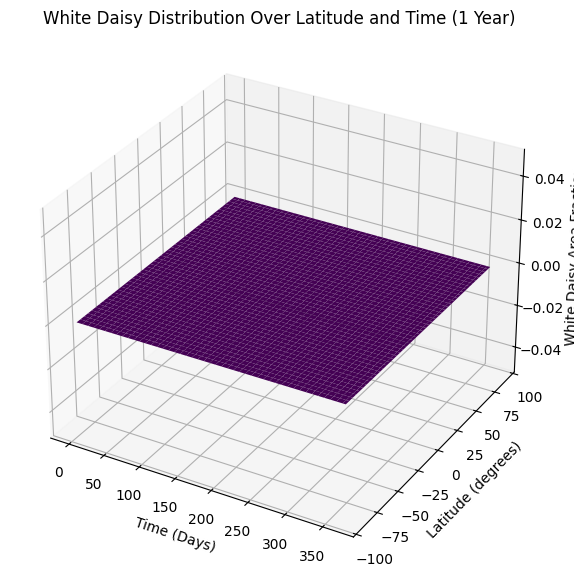

In [98]:
fig = plt.figure(figsize=(15, 7))
ax3d = fig.add_subplot(111, projection='3d')

time_steps = np.arange(365)
latitudes = np.arange(-90, 90)
white_daisy_array = np.array(white_daisy_by_latitude[:365])

T, L = np.meshgrid(time_steps, latitudes)
Z = white_daisy_array.T

ax3d.plot_surface(T, L, Z, cmap='viridis')
ax3d.set_xlabel('Time (Days)')
ax3d.set_ylabel('Latitude (degrees)')
ax3d.set_zlabel('White Daisy Area Fraction')
ax3d.set_title('White Daisy Distribution Over Latitude and Time (1 Year)')
plt.show()


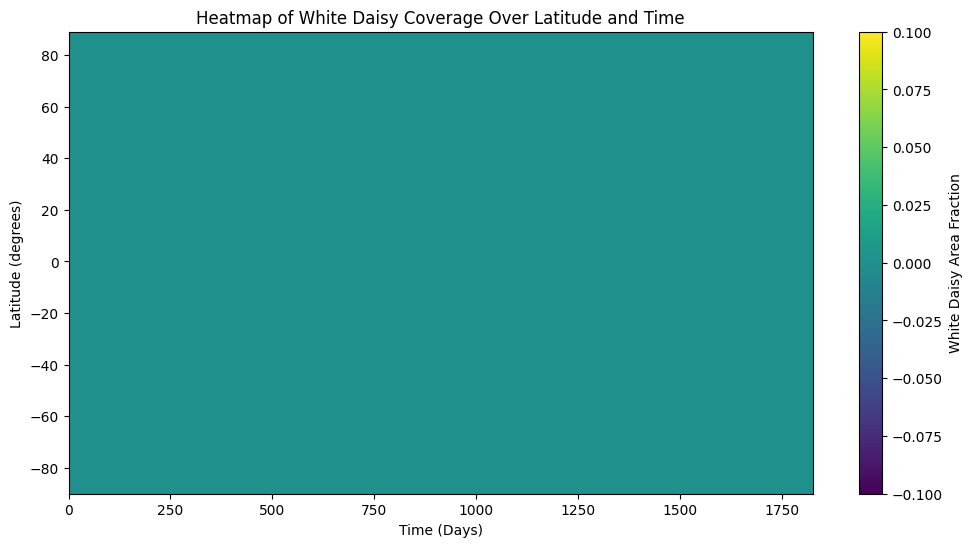

In [99]:
import matplotlib.pyplot as plt

# Convert white_daisy_by_latitude to a numpy array for plotting
white_daisy_matrix = np.array(white_daisy_by_latitude)

plt.figure(figsize=(12, 6))
plt.imshow(
    white_daisy_matrix.T,
    aspect='auto',
    origin='lower',
    extent=[0, len(white_daisy_by_latitude), -90, 89],
    cmap='viridis'
)
plt.colorbar(label='White Daisy Area Fraction')
plt.xlabel('Time (Days)')
plt.ylabel('Latitude (degrees)')
plt.title('Heatmap of White Daisy Coverage Over Latitude and Time')
plt.show()

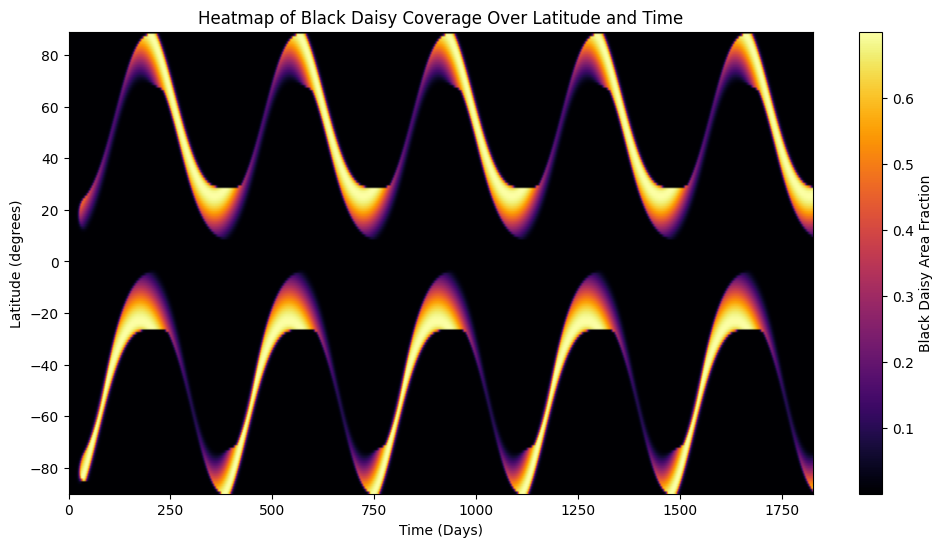

In [100]:
black_daisy_matrix = np.array(black_daisy_by_latitude)

plt.figure(figsize=(12, 6))
plt.imshow(
    black_daisy_matrix.T,
    aspect='auto',
    origin='lower',
    extent=[0, len(black_daisy_by_latitude), -90, 89],
    cmap='inferno'
)
plt.colorbar(label='Black Daisy Area Fraction')
plt.xlabel('Time (Days)')
plt.ylabel('Latitude (degrees)')
plt.title('Heatmap of Black Daisy Coverage Over Latitude and Time')
plt.show()

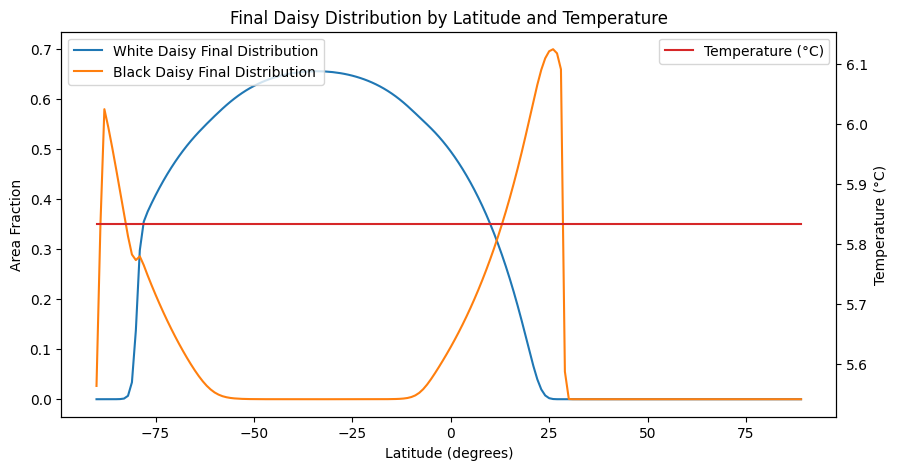

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot daisy distributions
ax1.plot(np.arange(-90, 90), white_daisy_by_latitude[-1], label='White Daisy Final Distribution')
ax1.plot(np.arange(-90, 90), black_daisy_by_latitude[-1], label='Black Daisy Final Distribution')
ax1.set_xlabel('Latitude (degrees)')
ax1.set_ylabel('Area Fraction')
ax1.legend(loc='upper left')

# Add secondary axis for temperature
ax2 = ax1.twinx()
ax2.plot(np.arange(-90, 90), [T_p_seq[-1] - K] * 180, color='tab:red', label='Temperature (°C)')
ax2.set_ylabel('Temperature (°C)')
ax2.legend(loc='upper right')

plt.title('Final Daisy Distribution by Latitude and Temperature')
plt.show()

**Animation**

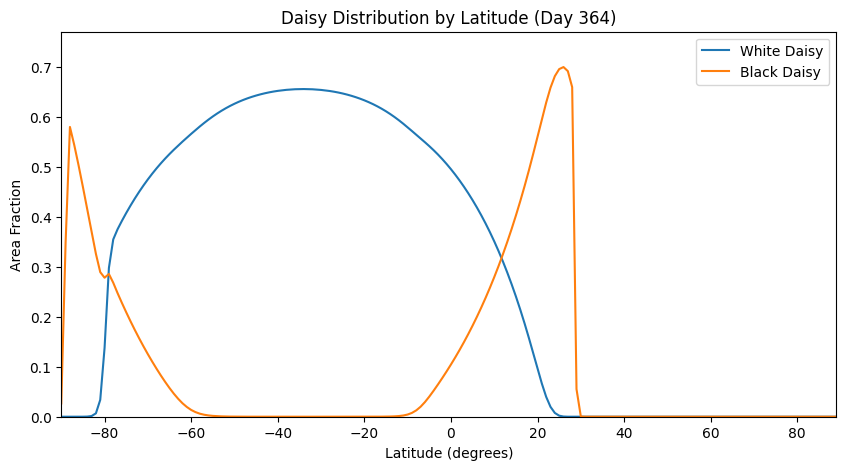

In [ ]:
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(figsize=(10, 5))
latitudes = np.arange(-90, 90)
line_white, = ax.plot([], [], label='White Daisy')
line_black, = ax.plot([], [], label='Black Daisy')
ax.set_xlim(-90, 89)
ax.set_ylim(0, max(np.max(white_daisy_by_latitude), np.max(black_daisy_by_latitude)) * 1.1)
ax.set_xlabel('Latitude (degrees)')
ax.set_ylabel('Area Fraction')
ax.set_title('Daisy Distribution by Latitude Over Time')
ax.legend()

def animate(i):
    line_white.set_data(latitudes, white_daisy_by_latitude[i])
    line_black.set_data(latitudes, black_daisy_by_latitude[i])
    ax.set_title(f'Daisy Distribution by Latitude (Day {i})')
    return line_white, line_black

anim = FuncAnimation(fig, animate, frames=365, interval=30, blit=True)
anim.save('daisy_distribution_animation_365_frames.gif', writer='pillow')
plt.show()

### Iteration 3: With Daisies, L = 2.5

In [78]:
# Solar multiplier
local_solar_multiplier = 2.5  # Simulates different solar intensities

# Initial conditions
T_p_seq = []
A_w_seq = []
A_b_seq = []
white_daisy_by_latitude = []
black_daisy_by_latitude = []

A_g = np.ones(180) * 0.0  # Initial bare ground area fraction
A_w = np.ones(180) * 0.0  # Initial white daisy area fraction
A_b = np.ones(180) * 0.0  # Initial black daisy area fraction

areas = np.array([area_fraction(lat - 90) for lat in range(180)])
albedo_p = np.zeros(180)

years = 5
for day in range(365 * years):
    delta_A_w = np.zeros(180)
    delta_A_b = np.zeros(180)
    T = np.zeros(180)

    for lat in range(0, 180):
        A_g[lat] = 1 - A_w[lat] - A_b[lat]
        albedo_p[lat] = A_g[lat] * albedo_g + A_w[lat] * albedo_w + A_b[lat] * albedo_b
        I_0 = daily_radiation(day, lat - 90, solar_constant=solar_constant, solar_multiplier=local_solar_multiplier)
        # print(I_0)
        T[lat] = (I_0 * (1 - albedo_p[lat]) / sigma) ** 0.25 if I_0 > 0 else T_min

        T_w = ((R * I_0 / sigma * (albedo_p[lat] - albedo_w)) + T[lat] ** 4) ** 0.25
        T_b = ((R * I_0 / sigma * (albedo_p[lat] - albedo_b)) + T[lat] ** 4) ** 0.25

        beta_w = 1 - 0.003265 * (295.65 - T_w) ** 2 if T_min < T_w < T_max else 0
        beta_b = 1 - 0.003265 * (295.65 - T_b) ** 2 if T_min < T_b < T_max else 0

        delta_A_w[lat] = A_w[lat] * (A_g[lat] * beta_w - gamma) * timestep
        delta_A_b[lat] = A_b[lat] * (A_g[lat] * beta_b - gamma) * timestep

        A_w[lat] += delta_A_w[lat]
        A_b[lat] += delta_A_b[lat]

    A_w = np.clip(A_w, 1e-6, 1.0)
    A_b = np.clip(A_b, 1e-6, 1.0)

    T_p_new = np.dot(T, areas)
    T_p_seq.append(T_p_new)
    A_w_seq.append(np.mean(A_w))
    A_b_seq.append(np.mean(A_b))
    white_daisy_by_latitude.append(A_w.copy())
    black_daisy_by_latitude.append(A_b.copy())

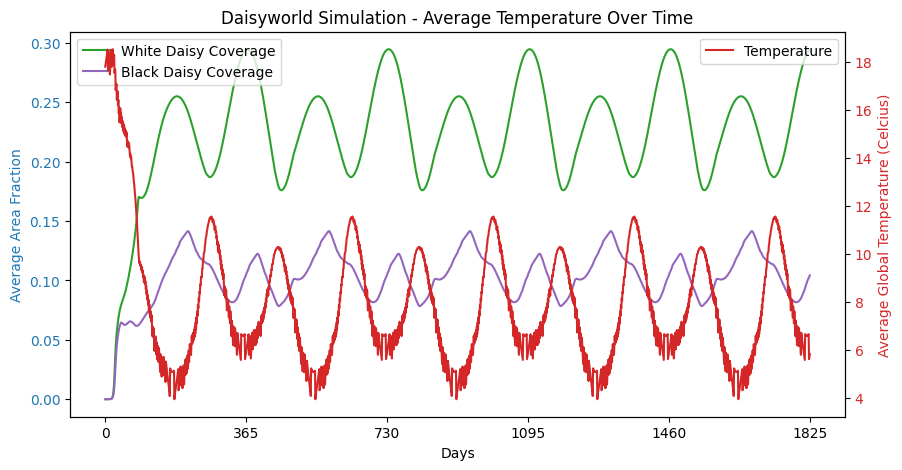

In [79]:
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.set_xticks(np.arange(0, len(A_w_seq)+1, 365))
ax1.set_xticklabels([str(i) for i in np.arange(0, len(A_w_seq)+1, 365)])

color1 = 'tab:blue'
ax1.set_xlabel('Days')
ax1.set_ylabel('Average Area Fraction', color=color1)
ax1.plot(A_w_seq, label='White Daisy Coverage', color='tab:green')
ax1.plot(A_b_seq, label='Black Daisy Coverage', color='tab:purple')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Average Global Temperature (Celcius)', color=color2)
ax2.plot(np.array(T_p_seq) - K, label='Temperature', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)
ax2.legend(loc='upper right')

plt.title('Daisyworld Simulation - Average Temperature Over Time')
plt.show()

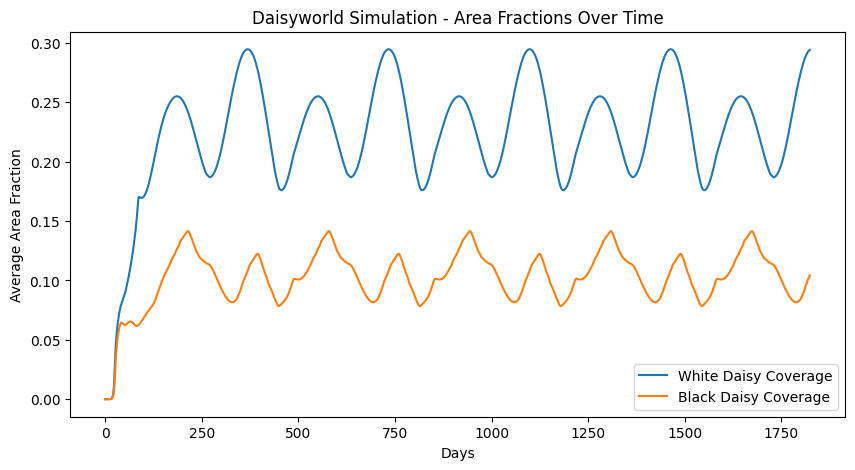

In [80]:
plt.figure(figsize=(10, 5))
plt.plot(A_w_seq, label = 'White Daisy Coverage')
plt.plot(A_b_seq, label = 'Black Daisy Coverage')
plt.xlabel('Days')
plt.ylabel('Average Area Fraction')
plt.title('Daisyworld Simulation - Area Fractions Over Time')
plt.legend()
plt.show()

**Plotting**

> Results suggest that daisy growth does not fluctuate significantly with the seasonal changes in sunlight or seasonal changes in temperture in Daisyworld.

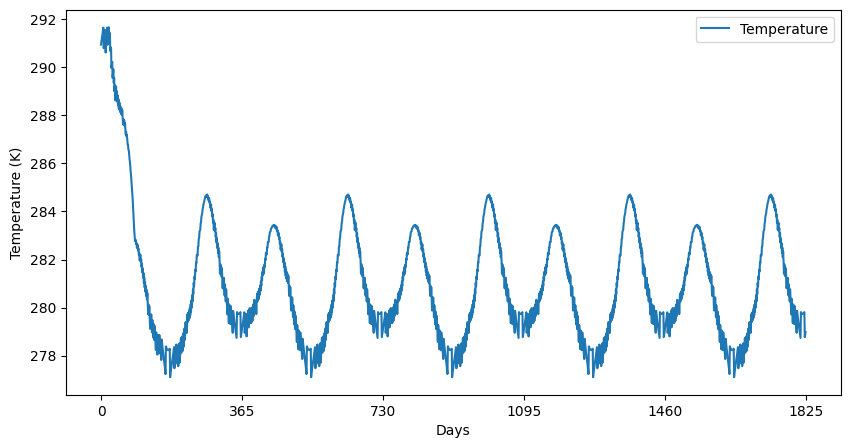

In [81]:
plt.figure(figsize=(10, 5))
plt.plot(T_p_seq, label = 'Temperature')
plt.xlabel('Days')
plt.ylabel('Temperature (K)')
plt.legend()
plt.xticks(
    ticks=np.arange(0, len(T_p_seq)+1, 365),
    labels=[str(i) for i in range(0, len(T_p_seq)+1, 365)]
)
plt.show()

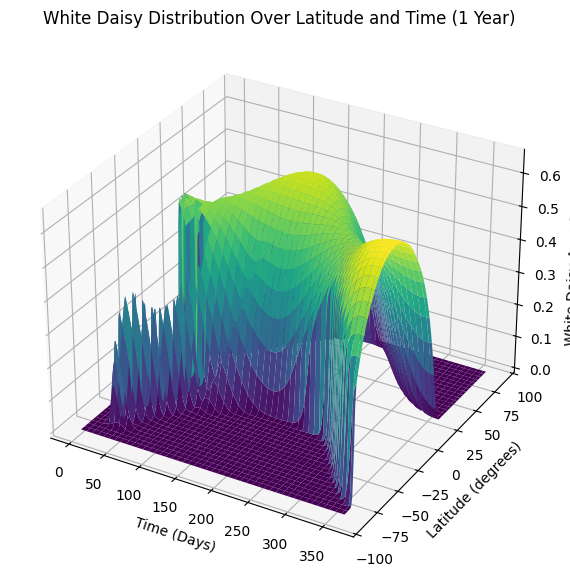

In [82]:
fig = plt.figure(figsize=(15, 7))
ax3d = fig.add_subplot(111, projection='3d')

time_steps = np.arange(365)
latitudes = np.arange(-90, 90)
white_daisy_array = np.array(white_daisy_by_latitude[:365])

T, L = np.meshgrid(time_steps, latitudes)
Z = white_daisy_array.T

ax3d.plot_surface(T, L, Z, cmap='viridis')
ax3d.set_xlabel('Time (Days)')
ax3d.set_ylabel('Latitude (degrees)')
ax3d.set_zlabel('White Daisy Area Fraction')
ax3d.set_title('White Daisy Distribution Over Latitude and Time (1 Year)')
plt.show()


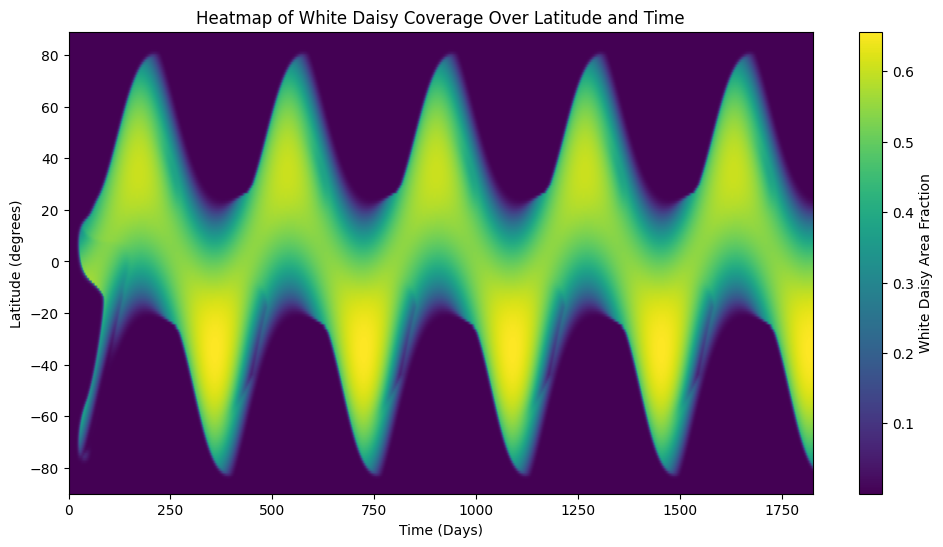

In [83]:
import matplotlib.pyplot as plt

# Convert white_daisy_by_latitude to a numpy array for plotting
white_daisy_matrix = np.array(white_daisy_by_latitude)

plt.figure(figsize=(12, 6))
plt.imshow(
    white_daisy_matrix.T,
    aspect='auto',
    origin='lower',
    extent=[0, len(white_daisy_by_latitude), -90, 89],
    cmap='viridis'
)
plt.colorbar(label='White Daisy Area Fraction')
plt.xlabel('Time (Days)')
plt.ylabel('Latitude (degrees)')
plt.title('Heatmap of White Daisy Coverage Over Latitude and Time')
plt.show()

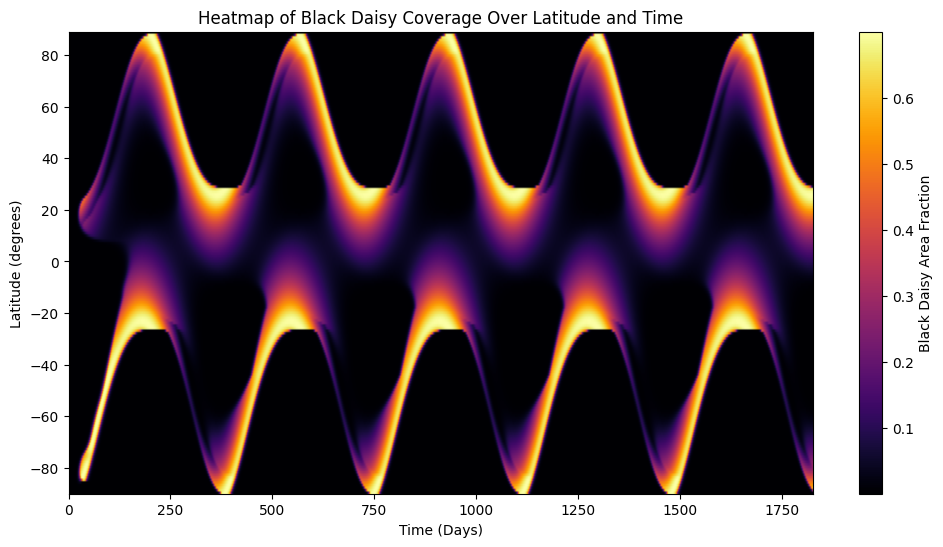

In [84]:
black_daisy_matrix = np.array(black_daisy_by_latitude)

plt.figure(figsize=(12, 6))
plt.imshow(
    black_daisy_matrix.T,
    aspect='auto',
    origin='lower',
    extent=[0, len(black_daisy_by_latitude), -90, 89],
    cmap='inferno'
)
plt.colorbar(label='Black Daisy Area Fraction')
plt.xlabel('Time (Days)')
plt.ylabel('Latitude (degrees)')
plt.title('Heatmap of Black Daisy Coverage Over Latitude and Time')
plt.show()

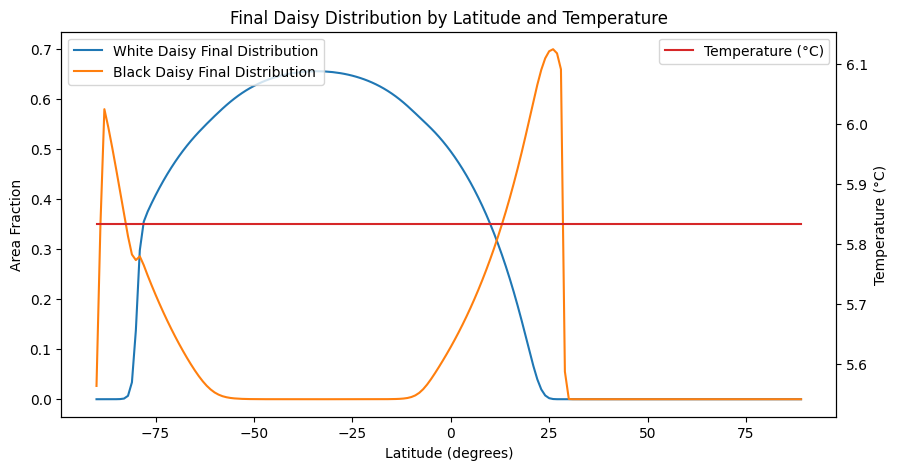

In [87]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot daisy distributions
ax1.plot(np.arange(-90, 90), white_daisy_by_latitude[-1], label='White Daisy Final Distribution')
ax1.plot(np.arange(-90, 90), black_daisy_by_latitude[-1], label='Black Daisy Final Distribution')
ax1.set_xlabel('Latitude (degrees)')
ax1.set_ylabel('Area Fraction')
ax1.legend(loc='upper left')

# Add secondary axis for temperature
ax2 = ax1.twinx()
ax2.plot(np.arange(-90, 90), [T_p_seq[-1] - K] * 180, color='tab:red', label='Temperature (°C)')
ax2.set_ylabel('Temperature (°C)')
ax2.legend(loc='upper right')

plt.title('Final Daisy Distribution by Latitude and Temperature')
plt.show()

**Animation**

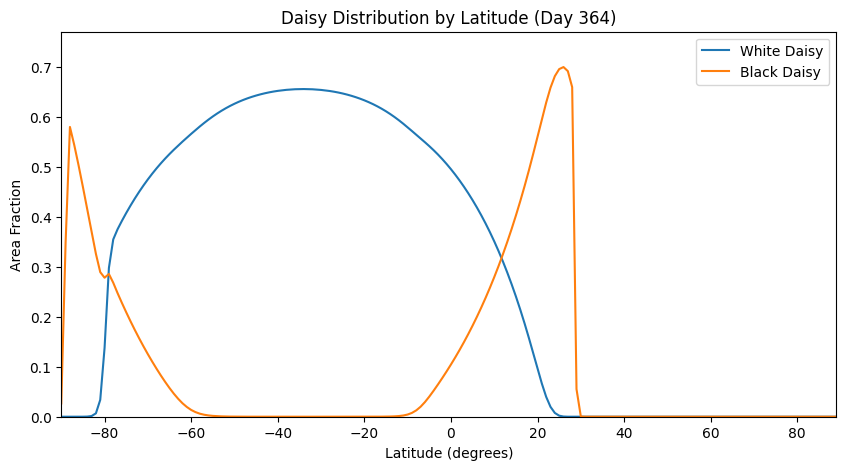

In [86]:
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(figsize=(10, 5))
latitudes = np.arange(-90, 90)
line_white, = ax.plot([], [], label='White Daisy')
line_black, = ax.plot([], [], label='Black Daisy')
ax.set_xlim(-90, 89)
ax.set_ylim(0, max(np.max(white_daisy_by_latitude), np.max(black_daisy_by_latitude)) * 1.1)
ax.set_xlabel('Latitude (degrees)')
ax.set_ylabel('Area Fraction')
ax.set_title('Daisy Distribution by Latitude Over Time')
ax.legend()

def animate(i):
    line_white.set_data(latitudes, white_daisy_by_latitude[i])
    line_black.set_data(latitudes, black_daisy_by_latitude[i])
    ax.set_title(f'Daisy Distribution by Latitude (Day {i})')
    return line_white, line_black

anim = FuncAnimation(fig, animate, frames=365, interval=30, blit=True)
anim.save('daisy_distribution_animation_365_frames.gif', writer='pillow')
plt.show()

### Iteration 2: No Daisies, L = 3

In [ ]:
# Solar multiplier
local_solar_multiplier = 3  # Simulates different solar intensities

# Initial conditions
T_p_seq = []
A_w_seq = []
A_b_seq = []
white_daisy_by_latitude = []
black_daisy_by_latitude = []

A_g = np.ones(180) * 0.0  # Initial bare ground area fraction
A_w = np.ones(180) * 0.0  # Initial white daisy area fraction
A_b = np.ones(180) * 0.0  # Initial black daisy area fraction

areas = np.array([area_fraction(lat - 90) for lat in range(180)])
albedo_p = np.zeros(180)

years = 5
for day in range(365 * years):
    delta_A_w = np.zeros(180)
    delta_A_b = np.zeros(180)
    T = np.zeros(180)

    for lat in range(0, 180):
        A_g[lat] = 1 - A_w[lat] - A_b[lat]
        albedo_p[lat] = A_g[lat] * albedo_g + A_w[lat] * albedo_w + A_b[lat] * albedo_b
        I_0 = daily_radiation(day, lat - 90, solar_constant=solar_constant, solar_multiplier=local_solar_multiplier)
        T[lat] = (I_0 * (1 - albedo_p[lat]) / sigma) ** 0.25 if I_0 > 0 else T_min

        T_w = ((R * I_0 / sigma * (albedo_p[lat] - albedo_w)) + T[lat] ** 4) ** 0.25
        T_b = ((R * I_0 / sigma * (albedo_p[lat] - albedo_b)) + T[lat] ** 4) ** 0.25

        beta_w = 1 - 0.003265 * (295.65 - T_w) ** 2 if T_min < T_w < T_max else 0
        beta_b = 1 - 0.003265 * (295.65 - T_b) ** 2 if T_min < T_b < T_max else 0

        delta_A_w[lat] = A_w[lat] * (A_g[lat] * beta_w - gamma) * timestep
        delta_A_b[lat] = A_b[lat] * (A_g[lat] * beta_b - gamma) * timestep

        A_w[lat] += delta_A_w[lat]
        A_b[lat] += delta_A_b[lat]
        # A_w[lat] = max(0.001, A_w[lat])
        # A_b[lat] = max(0.001, A_b[lat])

    # A_w = np.clip(A_w, 1e-6, 1.0)
    # A_b = np.clip(A_b, 1e-6, 1.0)

    T_p_new = np.dot(T, areas)
    T_p_seq.append(T_p_new)
    A_w_seq.append(np.mean(A_w))
    A_b_seq.append(np.mean(A_b))
    white_daisy_by_latitude.append(A_w.copy())
    black_daisy_by_latitude.append(A_b.copy())

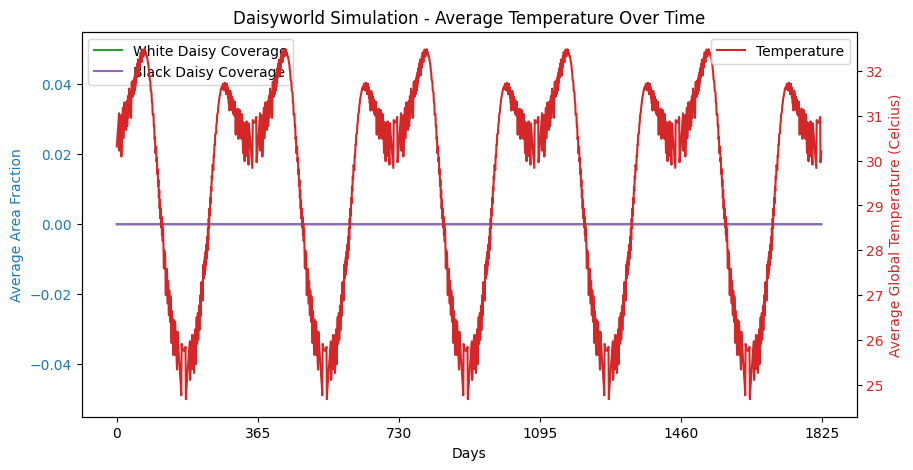

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.set_xticks(np.arange(0, len(A_w_seq)+1, 365))
ax1.set_xticklabels([str(i) for i in np.arange(0, len(A_w_seq)+1, 365)])

color1 = 'tab:blue'
ax1.set_xlabel('Days')
ax1.set_ylabel('Average Area Fraction', color=color1)
ax1.plot(A_w_seq, label='White Daisy Coverage', color='tab:green')
ax1.plot(A_b_seq, label='Black Daisy Coverage', color='tab:purple')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Average Global Temperature (Celcius)', color=color2)
ax2.plot(np.array(T_p_seq) - K, label='Temperature', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)
ax2.legend(loc='upper right')

plt.title('Daisyworld Simulation - Average Temperature Over Time')
plt.show()

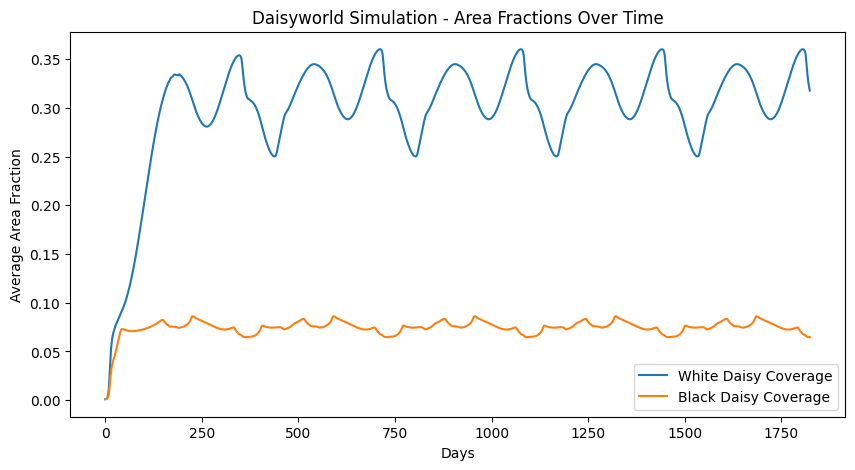

In [ ]:
# # Number of years to simulate
# years = 5

# # Initialize variables
# T_p_seq = []
# A_w_seq = []
# A_b_seq = []
# white_daisy_by_latitude = []
# black_daisy_by_latitude = []

# A_g = np.ones(180) * 0.3  # Initial bare ground area fraction
# A_w = np.ones(180) * 0.5  # Initial white daisy area fraction
# A_b = np.ones(180) * 0.2  # Initial black daisy area fraction

# T_p = 20 + K
# temperatures = np.ones(180) * T_p  # Temperature at each latitude

# area_proportion_by_latitude = \
#     np.vectorize(area_fraction)(np.arange(0, 180))

# for day in range(365 * years):

#     # Initialize changes in area fractions
#     delta_A_b = np.zeros(180)
#     delta_A_w = np.zeros(180)

#     # Loop over each latitude
#     for lat in range(-90, 89):

#         # Calculate temperature at each latitude
#         local_radiation = daily_radiation(day, lat, solar_multiplier=local_solar_multiplier)  # <-- use daily radiation
#         local_temperature = (local_radiation * (1 - A_p[lat]) / sigma) ** 0.25 if local_radiation > 0 else T_min
#         temperatures[lat] = local_temperature
#         print(f"Day {day}, Lat {lat}: Local Radiation={local_radiation}, Albedo_p={A_p[lat]}, Temperature={temperatures[lat]}")
        
#         # Calculate bare ground area fraction
#         A_g = max(0.0, 1 - A_w - A_b)

#         # Calculate planetary albedo at each latitude
#         A_p = A_g * albedo_g + A_w * albedo_w + A_b * albedo_b

#         # Calculate local temperatures for daisies
#         T_w = ((R * local_radiation / sigma * (A_p[lat + 90] - A_w[lat + 90])) + temperatures[lat] ** 4) ** 0.25
#         T_b = ((R * local_radiation / sigma * (A_p[lat + 90] - A_b[lat + 90])) + temperatures[lat] ** 4) ** 0.25

#         # Adjust growth rates based on temperature
#         beta_b = 1 - 0.003265 * (295.65 - T_b) ** 2 if T_min < T_b < T_max else 0
#         beta_w = 1 - 0.003265 * (295.65 - T_w) ** 2 if T_min < T_w < T_max else 0

#         # Update area fractions
#         delta_A_w[lat + 90] += A_w[lat + 90] * (A_g[lat + 90] * beta_w - gamma) * 1  # timestep = 1 day
#         delta_A_b[lat + 90] += A_b[lat + 90] * (A_g[lat + 90] * beta_b - gamma) * 1
#         # print(f"Day {day}, Lat {lat}: T_w={T_w}, T_b={T_b}, beta_w={beta_w}, beta_b={beta_b}, delta_A_w={delta_A_w[lat + 90]}, delta_A_b={delta_A_b[lat + 90]}")

#         # Debugging prints
#         # print(albedo_p, T_p_i, I_0)

#     T_p_new = sum(t * a for t, a in zip(temperatures, area_proportion_by_latitude))
#     # temperatures = np.ones(180) * T_p_new
#     T_p_seq.append(T_p_new)

#     A_w += delta_A_w
#     white_daisy_by_latitude.append(A_w)
#     A_w_seq.append(np.mean(A_w))

#     A_b += delta_A_b
#     black_daisy_by_latitude.append(A_b)
#     A_b_seq.append(np.mean(A_b))

plt.figure(figsize=(10, 5))
plt.plot(A_w_seq, label = 'White Daisy Coverage')
plt.plot(A_b_seq, label = 'Black Daisy Coverage')
plt.xlabel('Days')
plt.ylabel('Average Area Fraction')
plt.title('Daisyworld Simulation - Area Fractions Over Time')
plt.legend()
plt.show()

**Plotting**

> Results suggest that daisy growth does not fluctuate significantly with the seasonal changes in sunlight or seasonal changes in temperture in Daisyworld.

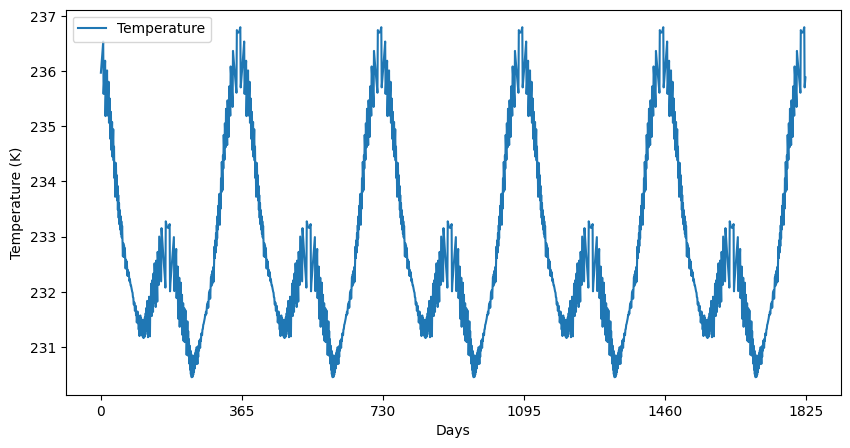

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(T_p_seq, label = 'Temperature')
plt.xlabel('Days')
plt.ylabel('Temperature (K)')
plt.legend()
plt.xticks(
    ticks=np.arange(0, len(T_p_seq)+1, 365),
    labels=[str(i) for i in range(0, len(T_p_seq)+1, 365)]
)
plt.show()

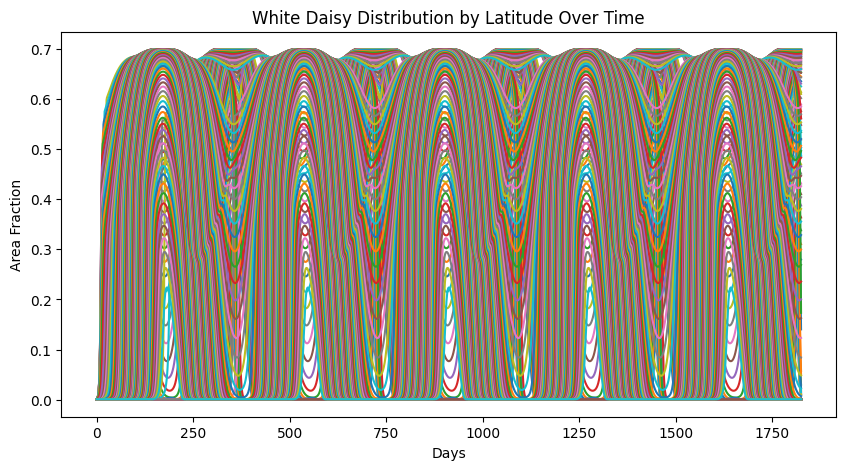

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(white_daisy_by_latitude, label='White Daisy Distribution by Latitude')
plt.xlabel('Days')
plt.ylabel('Area Fraction')
plt.title('White Daisy Distribution by Latitude Over Time')
# plt.legend()
plt.show()

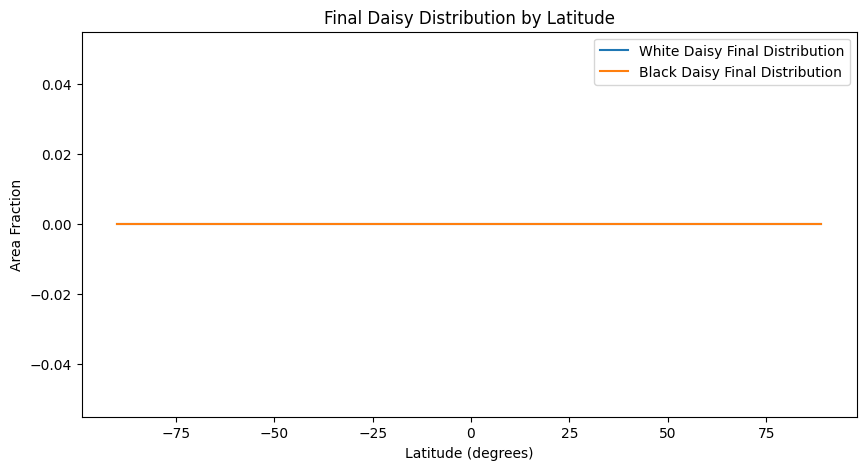

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(-90, 90), white_daisy_by_latitude[-1], label='White Daisy Final Distribution')
plt.plot(np.arange(-90, 90), black_daisy_by_latitude[-1], label='Black Daisy Final Distribution')
plt.xlabel('Latitude (degrees)')
plt.ylabel('Area Fraction')
plt.title('Final Daisy Distribution by Latitude')
plt.legend()
plt.show()

**Animation**

/var/folders/vc/lnct1rm96xd432sh6xst3xjr0000gn/T/ipykernel_49710/3375557083.py:8: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(0, max(np.max(white_daisy_by_latitude), np.max(black_daisy_by_latitude)) * 1.1)


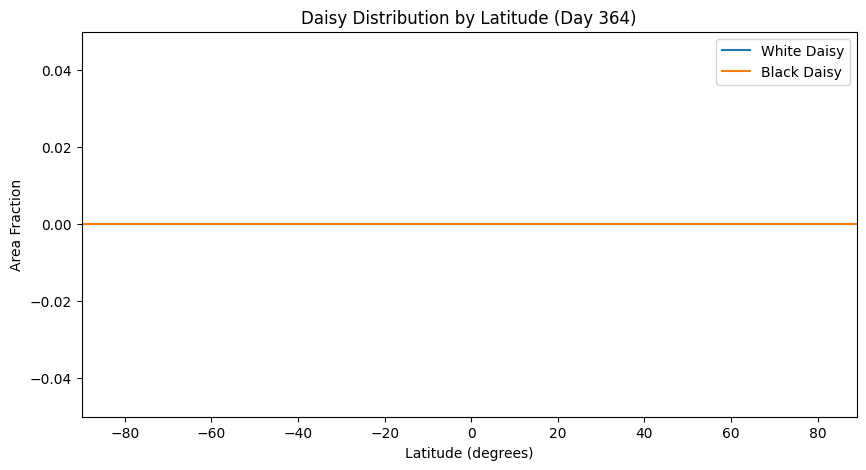

In [ ]:
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(figsize=(10, 5))
latitudes = np.arange(-90, 90)
line_white, = ax.plot([], [], label='White Daisy')
line_black, = ax.plot([], [], label='Black Daisy')
ax.set_xlim(-90, 89)
ax.set_ylim(0, max(np.max(white_daisy_by_latitude), np.max(black_daisy_by_latitude)) * 1.1)
ax.set_xlabel('Latitude (degrees)')
ax.set_ylabel('Area Fraction')
ax.set_title('Daisy Distribution by Latitude Over Time')
ax.legend()

def animate(i):
    line_white.set_data(latitudes, white_daisy_by_latitude[i])
    line_black.set_data(latitudes, black_daisy_by_latitude[i])
    ax.set_title(f'Daisy Distribution by Latitude (Day {i})')
    return line_white, line_black

anim = FuncAnimation(fig, animate, frames=365, interval=30, blit=True)
anim.save('daisy_distribution_animation_365_frames.gif', writer='pillow')
plt.show()

### Iteration 1: With Solar Declination, Eccentricity, and Daily Radiation Variations

In [28]:
T_p_seq = []
A_w_seq = []
A_b_seq = []
white_daisy_by_latitude = []
black_daisy_by_latitude = []

A_w = np.ones(180) * 0.8
A_b = np.ones(180) * 0.2
T_p = 20 + K
albedo_p = np.zeros(180)
areas = np.vectorize(area_fraction)(np.arange(0, 180))

years = 5

for time in range(365*years):

    delta_A_b = np.zeros(180)
    delta_A_w = np.zeros(180)

    T = np.zeros(180)

    for lat in range(0, 180):
        x = np.ones(180) - A_w - A_b
        albedo_p[lat] = A_w[lat] * albedo_w + x[lat] * albedo_g + A_b[lat] * albedo_b
        I_0 = daily_radiation(time, lat)  # <-- use daily radiation
        area_i = areas[lat]
        T[lat] = (I_0 * (1 - albedo_p[lat])/sigma)**0.25
        # print(albedo_p, T_p_i, I_0)

        T_w = ((R * I_0 / sigma * (albedo_p[lat] - albedo_w)) + T[lat] ** 4) ** 0.25
        T_b = ((R * I_0 / sigma * (albedo_p[lat] - albedo_b)) + T[lat] ** 4) ** 0.25
        if T_b <= T_max and T_b >= T_min:
            beta_b = 1 - 0.003265 * (295.65 - T_b) ** 2
        else:
            beta_b = 0
        if T_w <= T_max and T_w >= T_min:
            beta_w = 1 - 0.003265 * (295.65 - T_w)**2
        else:
            beta_w = 0

        delta_A_w[lat] += area_i * A_w[lat] * (x[lat] * beta_w - gamma) * 1  # timestep = 1 day
        delta_A_b[lat] += area_i * A_b[lat] * (x[lat] * beta_b - gamma) * 1

    T_p_new = np.dot(T, areas)
    T_p = np.ones(180) * T_p_new

    A_w += delta_A_w
    white_daisy_by_latitude.append(A_w)
    A_w_seq.append(np.mean(A_w))

    A_b += delta_A_b
    black_daisy_by_latitude.append(A_b)
    A_b_seq.append(np.mean(A_b))

    T_p_seq.append(T_p_new)

**Plotting**

> Results suggest that daisy growth does not fluctuate significantly with the seasonal changes in sunlight or seasonal changes in temperture in Daisyworld.

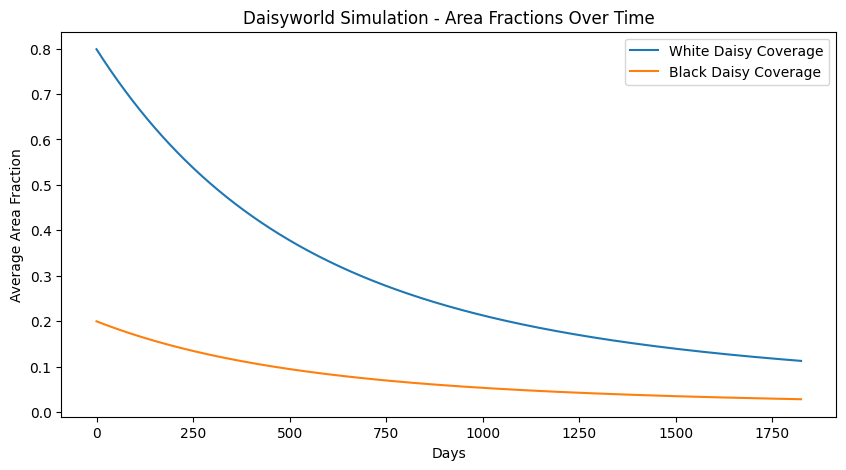

In [30]:
plt.figure(figsize=(10, 5))
plt.plot(A_w_seq, label = 'White Daisy Coverage')
plt.plot(A_b_seq, label = 'Black Daisy Coverage')
plt.xlabel('Days')
plt.ylabel('Average Area Fraction')
plt.title('Daisyworld Simulation - Area Fractions Over Time')
plt.legend()
plt.show()

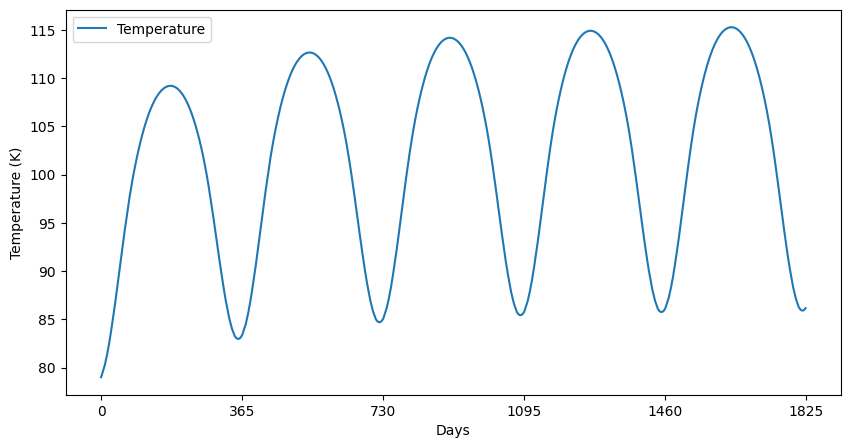

In [27]:
plt.figure(figsize=(10, 5))
plt.plot(T_p_seq, label = 'Temperature')
plt.xlabel('Days')
plt.ylabel('Temperature (K)')
plt.legend()
plt.xticks(
    ticks=np.arange(0, len(T_p_seq)+1, 365),
    labels=[str(i) for i in range(0, len(T_p_seq)+1, 365)]
)
plt.show()

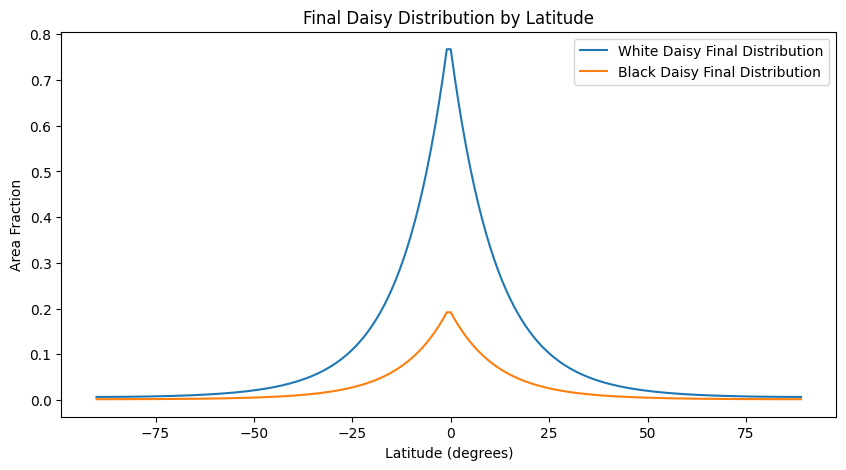

In [44]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(-90, 90), white_daisy_by_latitude[-100], label='White Daisy Final Distribution')
plt.plot(np.arange(-90, 90), black_daisy_by_latitude[-100], label='Black Daisy Final Distribution')
plt.xlabel('Latitude (degrees)')
plt.ylabel('Area Fraction')
plt.title('Final Daisy Distribution by Latitude')
plt.legend()
plt.show()

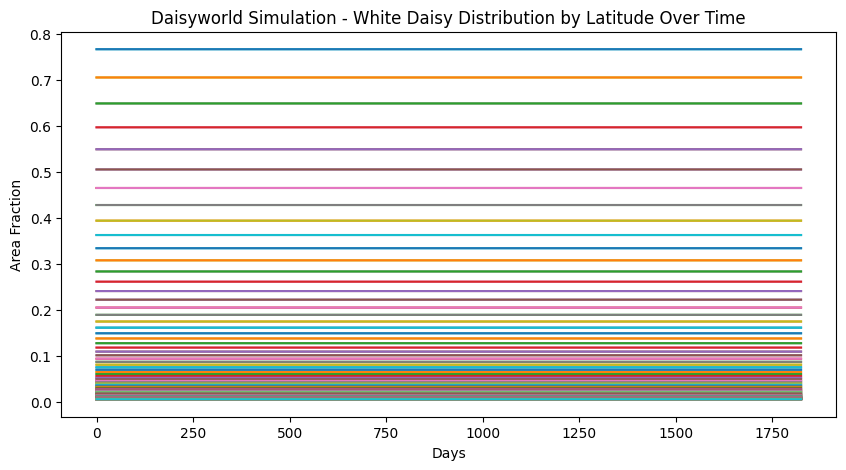

In [35]:
plt.figure(figsize=(10, 5))
plt.plot(white_daisy_by_latitude, label='White Daisy Distribution by Latitude')
plt.xlabel('Days')
plt.ylabel('Area Fraction')
plt.title('White Daisy Distribution by Latitude Over Time')
# plt.legend()
plt.show()

**Animation**

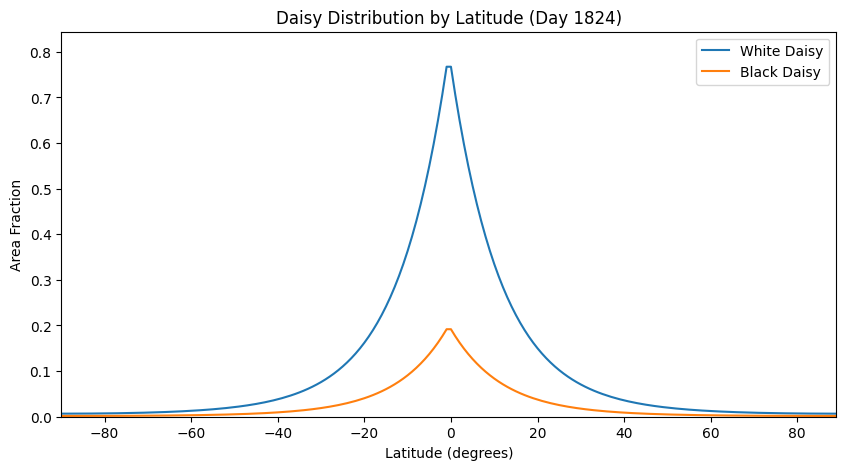

In [43]:
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(figsize=(10, 5))
latitudes = np.arange(-90, 90)
line_white, = ax.plot([], [], label='White Daisy')
line_black, = ax.plot([], [], label='Black Daisy')
ax.set_xlim(-90, 89)
ax.set_ylim(0, max(np.max(white_daisy_by_latitude), np.max(black_daisy_by_latitude)) * 1.1)
ax.set_xlabel('Latitude (degrees)')
ax.set_ylabel('Area Fraction')
ax.set_title('Daisy Distribution by Latitude Over Time')
ax.legend()

def animate(i):
    line_white.set_data(latitudes, white_daisy_by_latitude[i])
    line_black.set_data(latitudes, black_daisy_by_latitude[i])
    ax.set_title(f'Daisy Distribution by Latitude (Day {i})')
    return line_white, line_black

anim = FuncAnimation(fig, animate, frames=len(white_daisy_by_latitude), interval=30, blit=True)
anim.save('daisy_distribution_animation.gif', writer='pillow')
plt.show()